# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import f1_score

### Hyperparameters

In [2]:
# random seed
SEED = 42
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return torch.mean(focal_loss)

In [9]:

criterion1 = nn.CrossEntropyLoss()
criterion2 = FocalLoss(gamma=0.5)
criterion3 = FocalLoss(gamma=2)

criteria = [criterion1, criterion2, criterion3]

In [10]:
def train_batch(model, image, target, criterion):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

In [11]:
def test_batch(model, image, target, criterion):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

### Model Training

In [12]:
import os
import os.path as osp
import torch
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

# Define your constants here
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = 'models'  # Change this to your desired directory

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Test Loss', 'Test Acc', 'F1 Score'])

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model 这里是修改train_batch1234的地方
        outputs, loss = train_batch(model, image, target, criterion1)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # change learning rate
    scheduler.step()

    ##########################
    ### Testing
    ##########################
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, criterion1)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Calculate F1 Score
        f1 = f1_score(all_targets, all_preds, average='weighted')
        print(f'F1 Score: {f1:.4f}')

        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                'Epoch': [epoch + 1],
                'Train Loss': [epoch_loss],
                'Train Acc': [epoch_acc.item()],
                'Test Loss': [val_loss],
                'Test Acc': [val_acc.item()],
                'F1 Score': [f1]
            })
        ], ignore_index=True)

        # save the model in the last epoch
        if (epoch + 1) == NUM_EPOCHS:
            state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc.item(),
                'epoch': (epoch + 1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

# Save the results DataFrame to a CSV file
results_df.to_csv('CE_results.csv', index=False)


Epoch: 1/30 Train Loss: 0.0159 Acc: 0.2274
Begin test......
Test Loss: 0.0145 Acc: 0.2921
F1 Score: 0.2555
Epoch: 2/30 Train Loss: 0.0146 Acc: 0.2931
Begin test......
Test Loss: 0.0139 Acc: 0.3395
F1 Score: 0.3114
Epoch: 3/30 Train Loss: 0.0142 Acc: 0.3152
Begin test......
Test Loss: 0.0134 Acc: 0.3753
F1 Score: 0.3664
Epoch: 4/30 Train Loss: 0.0140 Acc: 0.3322
Begin test......
Test Loss: 0.0135 Acc: 0.3530
F1 Score: 0.3258
Epoch: 5/30 Train Loss: 0.0139 Acc: 0.3455
Begin test......
Test Loss: 0.0136 Acc: 0.3554
F1 Score: 0.3330
Epoch: 6/30 Train Loss: 0.0131 Acc: 0.3795
Begin test......
Test Loss: 0.0124 Acc: 0.4142
F1 Score: 0.4004
Epoch: 7/30 Train Loss: 0.0129 Acc: 0.3888
Begin test......
Test Loss: 0.0125 Acc: 0.4028
F1 Score: 0.3970
Epoch: 8/30 Train Loss: 0.0128 Acc: 0.3939
Begin test......
Test Loss: 0.0120 Acc: 0.4420
F1 Score: 0.4309
Epoch: 9/30 Train Loss: 0.0128 Acc: 0.4001
Begin test......
Test Loss: 0.0123 Acc: 0.4235
F1 Score: 0.4117
Epoch: 10/30 Train Loss: 0.0127 Acc: 

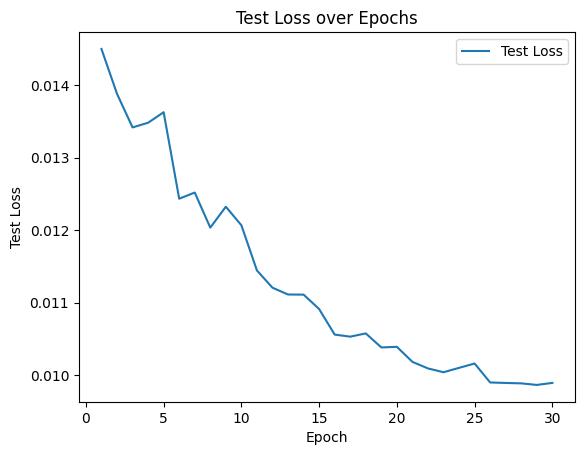

In [13]:
plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [14]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [15]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
input = input.to(device)
probabilities = F.softmax(model(input)[0],dim=0)
predict_label = torch.argmax(probabilities, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


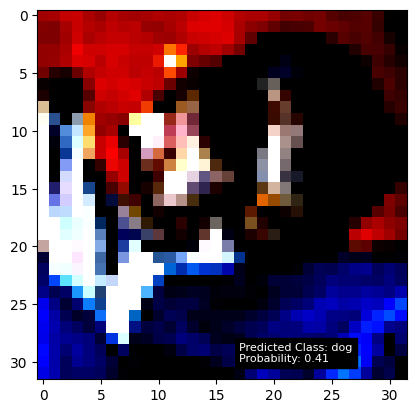

Print probabilities for each class:
airplane: 0.0113
automobile: 0.0006
bird: 0.0949
cat: 0.3718
deer: 0.0415
dog: 0.4110
frog: 0.0311
horse: 0.0289
ship: 0.0075
truck: 0.0015


In [16]:


predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')